In [8]:
from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image
import tensorflow as tf
from keras.layers import Input
from keras import backend as K
import keras
import skimage.transform

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# DeepDream
In this notebook I explore DeepDream, which is a method that can produce interesting images. The main idea of DeepDream is that you can take an image, and extract its output at an intermediate layer. That would indicate the response of the layer to a given input. Then, you can explore how changing that response would change the image. It is possible to change the image to maximize the response of the whole layer, but it is also possible to isolate only part of the response to maximize. This could mean choosing only some feature maps, or it could mean choosing only part of the image. The latter, however, will generate more localized responses.

In [5]:
input_tensor = Input(shape=(299, 299, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [6]:
x = base_model.input
y = base_model.output

In [18]:
img = plt.imread('./to_dream.jpg')
img = img[:img.shape[1]]
print(img.shape)
# img = scipy.misc.imresize(img, (img.shape[0]//3,img.shape[0]//3,3)).astype(np.float32)/img.max()
img = skimage.transform.resize(img, (299,299,3)).astype(np.float32)
img /= img.max()
# img = img.astype(np.float32)/img.max()

(3036, 3036, 3)


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [19]:
tmp = img.copy()

(-0.5, 298.5, 298.5, -0.5)

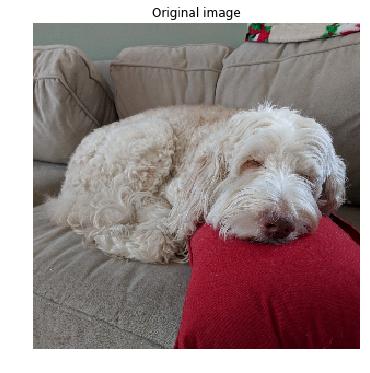

In [22]:
plt.figure(figsize=(6,6))
plt.title('Original image')
plt.imshow(img)
plt.axis('off')

In [26]:
grad_op = tf.gradients(y, x)

In [78]:
m = np.zeros((1, 17, 17, 768), dtype=np.float32)
m[:, 5:10, 5:10, 100:200] = 1
m2 = np.zeros((1, 17, 17, 768), dtype=np.float32)
m2[..., 100:200] = 1
int_grad100 = tf.gradients(base_model.layers[100].output, x)
intgrad2 = tf.gradients(base_model.layers[100].output * tf.constant(m), x)
intgrad3 = tf.gradients(base_model.layers[100].output * tf.constant(m2), x)

In [57]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = K.get_session()
K.set_learning_phase(0)
oo = sess.graph.get_operation_by_name('batch_normalization_1/keras_learning_phase').outputs[0]

In [58]:
eps = 1e-3
tmp = img.copy()

## Maximize whole response

In [ ]:
ints100 = []
tmp = img.copy()

for i in range(101):
    tmp += eps*sess.run(int_grad100, feed_dict={x:tmp[None], oo:False})[0][0]
    tmp -= tmp.min()
    tmp /= tmp.max()
    if i % 10 ==0 and i>0:
        ints100.append(tmp.copy())

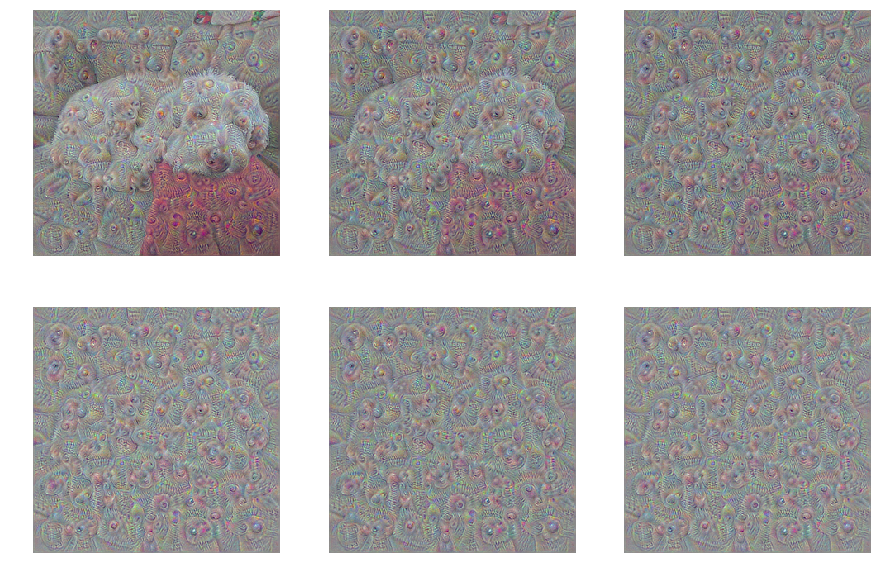

In [73]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(ints100[i])
    plt.axis('off')

## Maximize response of 100 feature maps

In [81]:
eps = 1e-3
tmp = img.copy()

intsm = []

for i in range(101):
    tmp += eps*sess.run(intgrad3, feed_dict={x:tmp[None], oo:False})[0][0]
    tmp -= tmp.min()
    tmp /= tmp.max()
    if i % 5 ==0 and i>0:
        intsm.append(tmp.copy())

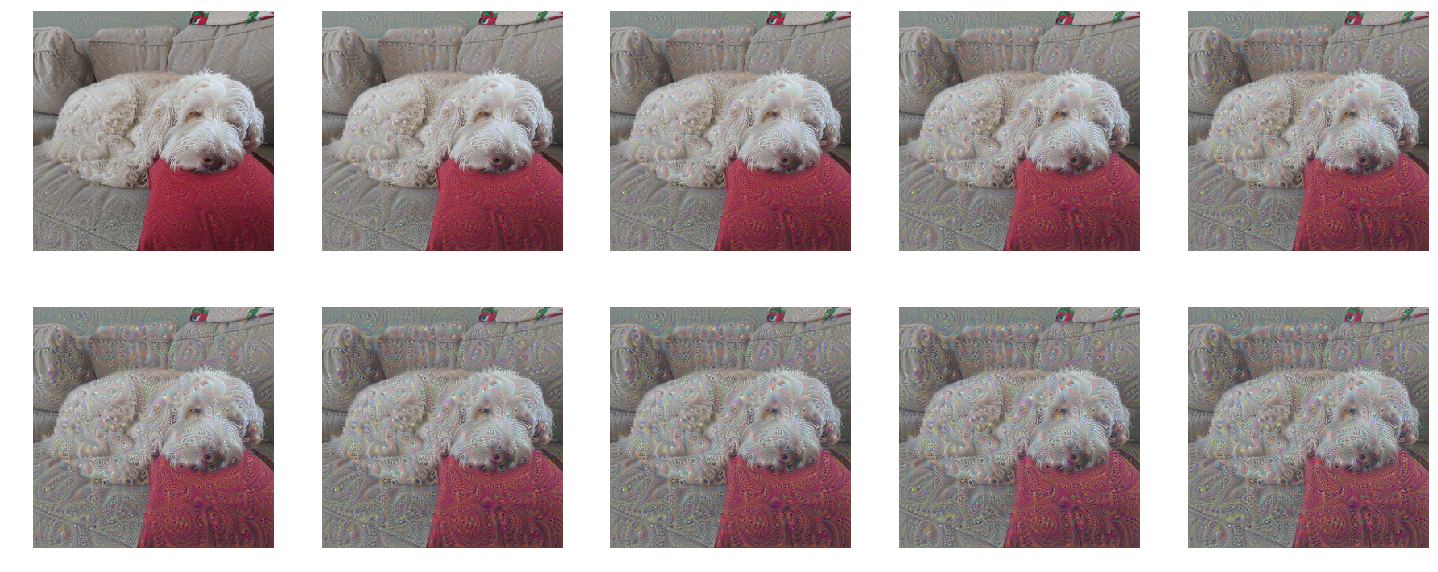

In [82]:
plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(intsm[2 * i + 1])
    plt.axis('off')